## Лабораторная работа № 2. K-means

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from typing import Literal
from warnings import filterwarnings

filterwarnings('ignore')

Необходимые функции и классы:

In [2]:
def hist(df: pd.DataFrame, title_text: str): 
    BAR_COLORS = ['#D9A23E', '#C47451', '#D9A23E', '#6B8E7A', '#C47451', '#99A3B8'] * 2 
    BAR_COLORS = BAR_COLORS[:len(df.columns)] 

    PLOT_BG_COLOR = '#2D2A26'    
    AXIS_COLOR = '#D9CAB3'       
    GRID_COLOR = '#736E66'   
    TITLE_FONT_COLOR = 'white'

    AXIS_LABELS = {'yaxis_title': 'Частота'}

    ROWS = 4
    COLS = 3
    N_PLOTS = len(df.columns) 

    fig = make_subplots(
        rows=ROWS, 
        cols=COLS, 
        horizontal_spacing=0.05, 
        vertical_spacing=0.08,
        subplot_titles=[f'Распределение {col}' for col in df.columns]
    )

    for i, col in enumerate(df.columns):

        row = (i // COLS) + 1
        col_idx = (i % COLS) + 1
        
        current_color = BAR_COLORS[i]

        hist_trace = go.Histogram(
            x=df[col],
            name=col,
            marker=dict(
                color=current_color,
                line=dict(width=0.5, color=AXIS_COLOR) 
            ),
            xbins=dict(size=1.0) 
        )

        fig.add_trace(hist_trace, row=row, col=col_idx)

    fig.update_layout(
        title={
            'text': title_text,
            'y': 0.98,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top',
            'font': {'size': 18, 'color': TITLE_FONT_COLOR} 
        },
        showlegend=False,
        autosize=True,
        height=800,
        plot_bgcolor=PLOT_BG_COLOR, 
        paper_bgcolor=PLOT_BG_COLOR, 
        font_color=AXIS_COLOR, 
        font=dict(color=AXIS_COLOR) 
    )

    for i in range(1, N_PLOTS + 1):
        r = (i - 1) // COLS + 1
        c = (i - 1) % COLS + 1
        
        fig.update_xaxes(
            color=AXIS_COLOR,
            gridcolor=GRID_COLOR,
            row=r, col=c
        )
        
        fig.update_yaxes(
            title_text=AXIS_LABELS['yaxis_title'] if c == 1 else None,
            color=AXIS_COLOR,
            gridcolor=GRID_COLOR,
            row=r, col=c
        )

    fig.show()



def boxplots(df):

    PLOT_BG_COLOR = '#2D2A26'
    AXIS_COLOR = '#D9CAB3'
    TITLE_COLOR = 'white'

    df_melted = df.melt(var_name='Переменная', value_name='Значение')

    fig = px.box(
        df_melted,
        x='Переменная',
        y='Значение',
        title='Ящик с усами',
        color_discrete_sequence=['#D9A23E'] 
    )

    fig.update_layout(
        title={
            'text': 'Ящик с усами',
            'x': 0.5,
            'font': {'size': 18, 'color': TITLE_COLOR}
        },
        height=500,
        width=600,
        plot_bgcolor=PLOT_BG_COLOR,
        paper_bgcolor=PLOT_BG_COLOR,
        font=dict(color=AXIS_COLOR),
        xaxis=dict(
            tickfont=dict(color=AXIS_COLOR),
            linecolor=AXIS_COLOR,
            gridcolor='#736E66'
        ),
        yaxis=dict(
            tickfont=dict(color=AXIS_COLOR),
            linecolor=AXIS_COLOR,
            gridcolor='#736E66'
        )
    )

    fig.show()



def scale(df, scaler: str = 'Standard'):
    if scaler == 'Standard':
        model = StandardScaler().fit(df)
    else:
        model = MinMaxScaler().fit(df)
        
    scaled_df = model.transform(df)

    return pd.DataFrame(scaled_df, columns=df.columns, index=df.index)



class kmeans_clustering:

    def __init__(self, df: pd.DataFrame, n_clusters: int = 3, max_iter: int = 300, 
                 random_state: int = 0, algorithm: str = 'lloyd', origin_df: pd.DataFrame = None):

        self.df = df
        self._df_result = None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.algorithm = algorithm
        self.origin_df = origin_df

        self.clustering()


    def clustering(self):
        self.kmeans = KMeans(n_clusters=self.n_clusters, 
                        random_state=self.random_state, 
                        max_iter=self.max_iter,
                        algorithm=self.algorithm).fit(self.df)
        
        if self.origin_df is None:
            self._df_result = self.df.copy()

        else:
            self._df_result = self.origin_df.copy()
        
        self._df_result['cluster'] = self.kmeans.labels_
        
        return self._df_result


    def scatter_plot(self, color='earth'):
        if self._df_result is None:
            self.clustering() 

        PLOT_BG_COLOR = '#2D2A26'
        AXIS_COLOR = '#D9CAB3'
        
        dimensions = self._df_result.columns[:-1]

        fig = px.scatter_matrix(
            self._df_result,
            dimensions=dimensions,
            color='cluster',
            title=f'Матрица рассеяния, окрашенная по кластерам (K={self.n_clusters})',
            height=750, 
            width=850,
            color_continuous_scale=color
        )

        fig.update_traces(
            diagonal_visible=False,
            marker=dict(size=5, opacity=0.8),
            showupperhalf=False
        )

        fig.update_layout(
            title_x=0.5,
            paper_bgcolor=PLOT_BG_COLOR,
            plot_bgcolor=PLOT_BG_COLOR,
            font=dict(color=AXIS_COLOR)
        )

        for annotation in fig.layout.annotations:
            annotation.font.color = AXIS_COLOR

        fig.show()


    def plot_distance_change(self):
        dist = []
        cluster_range = range(1, 16) 

        for k in cluster_range:
            # Инициализация K-Means с текущим k
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, 
                        max_iter=self.max_iter,
                        algorithm=self.algorithm)
            kmeans.fit(self.df)
            
            # Извлекаем инерцию
            dist.append(kmeans.inertia_)

        plt.rcParams['axes.facecolor'] = '#2D2A26'
        fig, ax = plt.subplots(figsize=(9, 4), 
                               facecolor='#2D2A26', 
                               edgecolor='#2D2A26')
        
        ax.plot(cluster_range, dist, marker='o', color='#D9A23E')
        ax.set_title('Расстояние между объединяемыми кластерами', color='white')
        ax.set_xlabel('Шаг объединения', color='#D9CAB3')
        ax.set_ylabel('Расстояние', color='#D9CAB3')
        
        ax.tick_params(axis='x', colors='#D9CAB3')
        ax.tick_params(axis='y', colors='#D9CAB3')
        ax.grid(color='#736E66', linestyle='--', linewidth=0.5)

        plt.show()


    def mean_by_cluster(self):
        df_result = self._df_result

        return df_result.groupby('cluster').mean()
    
    def cluster_size(self):
        df_result = self._df_result

        return df_result.groupby('cluster').size()


### Данные: Леденцы

Набор данных содержит оценки степени согласия респондентов с высказываниями, 
отражающими цель потребления леденцов. Всего каждый респондент выставлял оценки по 
11 высказываниям:

V1: Я потребляю леденцы, чтобы освежить дыхание

V2: Я потребляю леденцы, чтобы чувствовать себя увереннее

V3: Я потребляю леденцы, чтобы освежить полость рта

V4: Я потребляю леденцы, чтобы избавиться от неприятного вкуса во рту

V5: Я потребляю леденцы как заменитель других кондитерских изделий

V6: Я потребляю леденцы, когда мне хочется чего-нибудь сладкого

V7: Леденцы помогают мне сконцентрироваться

V8: Я потребляю леденцы, чтобы отвлечься на несколько минут и подумать

V9: Я потребляю леденцы для того, чтобы облегчить боль в горле

V10: Я потребляю леденцы для того, чтобы избавиться от заложенности носа

V11: Я потребляю леденцы для улучшения самочувствия

##### Разведочный анализ данных

In [3]:
df = pd.read_csv('data/Леденцы.dat', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V1      338 non-null    int64
 1   V2      338 non-null    int64
 2   V3      338 non-null    int64
 3   V4      338 non-null    int64
 4   V5      338 non-null    int64
 5   V6      338 non-null    int64
 6   V7      338 non-null    int64
 7   V8      338 non-null    int64
 8   V9      338 non-null    int64
 9   V10     338 non-null    int64
 10  V11     338 non-null    int64
dtypes: int64(11)
memory usage: 29.2 KB


In [4]:
# Проверка наличия пропусков
df.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
dtype: int64

In [5]:
# Описательная статистика
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
count,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000,338.000000
mean,3.544379,3.526627,3.517751,3.411243,3.207101,3.204142,3.254438,3.289941,3.603550,3.550296,3.565089
std,0.955748,0.956410,0.990150,0.992311,0.867314,0.869725,0.844107,0.821784,0.969682,0.927082,0.942042
min,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,5.000000,5.000000,5.000000,4.000000,3.000000,3.000000,3.000000,3.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [6]:
hist(df, title_text='Распределение оценок согласия с целями потребления леденцов')

In [7]:
# Корреляция
df.corr().style.background_gradient(cmap='Pastel2_r')

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
V1,1.000000,0.899539,0.899093,0.861459,-0.039758,-0.037705,-0.131739,-0.224225,-0.432416,-0.422820,-0.425076
V2,0.899539,1.000000,0.974008,0.918605,-0.056749,-0.051146,-0.170143,-0.243930,-0.410932,-0.408131,-0.410322
V3,0.899093,0.974008,1.000000,0.933310,-0.028481,-0.023172,-0.161636,-0.232446,-0.431511,-0.417980,-0.422759
V4,0.861459,0.918605,0.933310,1.000000,0.049004,0.053720,-0.082780,-0.146652,-0.474584,-0.462838,-0.465190
V5,-0.039758,-0.056749,-0.028481,0.049004,1.000000,0.990175,0.008874,-0.105314,-0.537177,-0.518580,-0.517738
V6,-0.037705,-0.051146,-0.023172,0.053720,0.990175,1.000000,0.038171,-0.087211,-0.554675,-0.533518,-0.532365
V7,-0.131739,-0.170143,-0.161636,-0.082780,0.008874,0.038171,1.000000,0.937104,-0.383938,-0.372838,-0.371665
V8,-0.224225,-0.243930,-0.232446,-0.146652,-0.105314,-0.087211,0.937104,1.000000,-0.257491,-0.260681,-0.262098
V9,-0.432416,-0.410932,-0.431511,-0.474584,-0.537177,-0.554675,-0.383938,-0.257491,1.000000,0.972884,0.963874
V10,-0.422820,-0.408131,-0.417980,-0.462838,-0.518580,-0.533518,-0.372838,-0.260681,0.972884,1.000000,0.991760


По матрице можно предварительно понять какие утверждения говорят примерно об одном и том же

##### Кластеризация

Возьмём 4 кластера и посмортим будут ли отличаться кластеры 

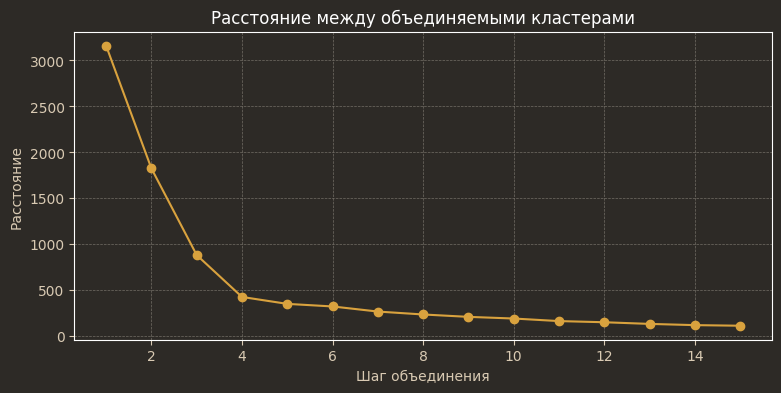

cluster
0    108
1    110
2     61
3     59
dtype: int64 

Silhouette Coefficient: 0.727


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11
cluster,,,,,,,,,,,
0,2.824074,2.833333,2.768519,2.620370,2.611111,2.583333,2.750000,2.916667,4.953704,4.814815,4.861111
1,4.845455,4.800000,4.836364,4.681818,3.036364,3.036364,3.000000,2.990909,3.072727,3.045455,3.045455
2,3.000000,3.000000,3.000000,3.000000,4.852459,4.852459,3.000000,2.918033,2.754098,2.754098,2.754098
3,3.000000,2.966102,2.966102,2.915254,2.915254,2.949153,4.915254,4.915254,3.000000,3.000000,3.000000


In [8]:
n_clusters=4
max_iter=300
random_state=0
algorithm='lloyd'

kmeans = kmeans_clustering(df, n_clusters=n_clusters, max_iter=max_iter, random_state=random_state)

kmeans.plot_distance_change()

print(kmeans.cluster_size(), '\n')

try:
    print(f'Silhouette Coefficient: {silhouette_score(df, kmeans.kmeans.labels_):.3f}')
except:
    pass

kmeans.mean_by_cluster()

Выводы: 

- результаты kmeans идентичны результатам иерархической кластеризации

### Данные: Экономика городов

Данные описывают экономические условия в 48 городах мира в 1991 году. 
Данные были собраны отделом экономических исследований банка Union (Швейцария). 
Описаны экономические условия в 48 городах мира в 1991 году. 


Число наблюдений: 48 

Названия переменных: 
- City (Город): Название города

- Работа (Work): Взвешенное среднее числа рабочих часов, сосчитанное по 12 
профессиям 

- Цена (Price): Индекс цен 112 товаров и услуг, включая арендную плату за 
жилье (значение для Цюриха взято за 100%) 

- Заработная плата (Salary): Индекс заработной платы за час работы, 
сосчитанный по 12 профессиям после налогов и вычетов  (значение для Цюриха 
взято за 100%)

##### Разведочный анализ данных

In [9]:
df = pd.read_csv('data/Econom_Cities_data.csv', sep=';', decimal=',').set_index('City', drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, Amsterdam to Zurich
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Work    48 non-null     int64  
 1   Price   48 non-null     float64
 2   Salary  48 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.5+ KB


In [10]:
# Проверка наличия пропусков
df.isna().sum()

Work      0
Price     0
Salary    0
dtype: int64

In [11]:
# Описательная статистика
df.describe()

,Work,Price,Salary
count,48.000000,48.000000,48.000000
mean,1384.958333,68.860417,-378.727083
std,2404.897007,21.784659,2027.338052
min,-9999.000000,30.300000,-9999.000000
25%,1740.750000,49.650000,12.250000
50%,1834.500000,70.500000,40.300000
75%,1972.750000,81.700000,58.700000
max,2375.000000,115.500000,100.000000


Видно подозрительные значения в строке min. Такого быть не может, поэтому нужно удалить эти выбросы:

In [12]:
indexes_for_drop = df[(df['Work'] < 0) | (df['Salary'] < 0)].index

df.drop(index=indexes_for_drop, inplace=True)

df.describe()

,Work,Price,Salary
count,46.000000,46.000000,46.000000
mean,1879.913043,70.100000,39.545652
std,174.342552,21.389177,24.757703
min,1583.000000,30.300000,2.700000
25%,1745.250000,51.775000,14.375000
50%,1849.000000,70.950000,43.650000
75%,1976.250000,81.900000,59.700000
max,2375.000000,115.500000,100.000000


In [13]:
# Проверка на выбросы
boxplots(df[['Work']])
boxplots(df[['Salary', 'Price']])

В целом, сильных выбросов не осталось, пока оставим наблюдение со значением 2375 признака Work. Перед кластеризацией также нормализуем данные, поскольку значения в колонке Work сильно отличаются от Price и Salary:

In [14]:
df_scaled = scale(df, scaler='Standard')
df_scaled.head()

,Work,Price,Salary
City,,,
Amsterdam,-0.962166,-0.212712,0.386095
Athens,-0.509827,-0.770489,-0.373488
Bogota,1.577891,-1.522069,-1.145323
Bombay,0.997969,-1.881316,-1.398517
Brussels,-0.996961,0.174896,0.447351


##### Кластеризация

Возьмём также 5 кластеров и сравним результат:

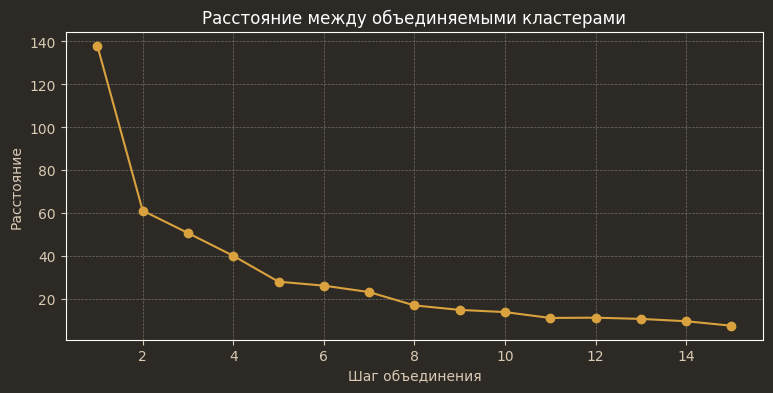

cluster
0    14
1    14
2     6
3     6
4     6
dtype: int64
                Work       Price     Salary
cluster                                    
0        1893.428571   53.664286  16.892857
1        1732.000000   78.135714  53.614286
2        1990.833333   77.233333  55.316667
3        1780.500000  108.550000  71.300000
4        2182.000000   44.116667  12.050000
City
Athens            0
Buenos_Aires      0
Caracas           0
Nairobi           0
Mexico_City       0
Lisbon            0
Lagos             0
Johannesburg      0
Nicosia           0
Singpore          0
Rio_de_Janeiro    0
Tel_Aviv          0
Seoul             0
San_Paulo         0
Frankfurt         1
Madrid            1
Montreal          1
Milan             1
Luxembourg        1
London            1
Brussels          1
Dusseldorf        1
Dublin            1
Copenhagen        1
Paris             1
Vienna            1
Sydney            1
Amsterdam         1
New_York          2
Chicago           2
Houston           2
Los_An

In [15]:
n_clusters=5
max_iter=300
random_state=0

kmeans = kmeans_clustering(df_scaled, n_clusters=n_clusters, max_iter=max_iter, random_state=random_state, origin_df=df)

kmeans.scatter_plot(color='sunset')
kmeans.plot_distance_change()

print(kmeans.cluster_size())
print(kmeans.mean_by_cluster())
print(kmeans._df_result['cluster'].sort_values(), '\n')

try:
    print(f'Silhouette Coefficient: {silhouette_score(df_scaled, kmeans.kmeans.labels_):.3f}')
except:
    pass

В результате разбиения данных на 5 кластеров алгоритмом $K-means$ выявлены те же характеристические группы, но с различиями:

- кластер 0 - разнородный, включающий города Южной Европы, Ближнего Востока, Африки и Латинской Америки. Показатели находятся в 'бедном' диапазоне (Salary низкий, Price низкий). Рабочая нагрузка умеренная. Это переходная группа между бедными и богатыми городами

- кластер 1 - это ядро развитых городов. Он характеризуется самой низкой рабочей нагрузкой из всех 1732.0, при этом Salary и Price высоки

- 3-й - кластер высокооплачиваемых, но более трудоемких центров

- самая богатая и дорогая группа это 4-ый кластер. Он выделяется самой высокой заработной платой и экстремально высокой стоимостью жизни

- в 5-ом кластере города с наиболее неблагоприятными условиями. Он сочетает самую высокую рабочую нагрузку с самой низкой оплатой труда

### Данные: Цифры

Каждая строка набора данных описывает цифру. Цифры отсканированы с ошибками. В обучающей выборке присутствует группирующая переменная - правильная цифра.

Первый этап. Сначала кластеризуем наблюдения, чтобы похожие цифры собрались в группы. Определить число кластеров и разбить цифры на кластеры. Также предложить интерпретацию для каждого кластера. 

Группирующую переменную 'A' нельзя использовать при кластеризации, 
но рекомендуется использовать ее при интерпретации кластеров.

В данных 7 переменных с именами 'B' - 'H', измеренных в номинальной шкале 
0 = линия присутствует 
1 = линия отсутствует 

Линии соответствуют черточкам на экране калькулятора

B - top horizontal, 
C - upper left vertical, 
D - upper right vertical, 
E - middle horizontal, 
F - lower left vertical, 
G - lower right vertical, 
H - bottom horizontal.  

В наборе данных 8 переменных и 500 наблюдений. По неизвестной причине в таблице данных каждый столбец присутствует дважды

In [16]:
# Загружаем данные и избавляемся от дублирующихся столбцов
df = pd.read_csv('data/digit.dat', sep=';').iloc[:, :8]

df = df.apply(lambda x: x.str.strip() if x.dtype == object else x).set_index('A')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, seven to seven
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   B       500 non-null    object
 1   C       500 non-null    object
 2   D       500 non-null    object
 3   E       500 non-null    object
 4   F       500 non-null    object
 5   G       500 non-null    object
 6   H       500 non-null    object
dtypes: object(7)
memory usage: 31.2+ KB


##### Разведочный анализ данных

In [17]:
# Проверка наличия пропусков
df.isna().sum()

B    0
C    0
D    0
E    0
F    0
G    0
H    0
dtype: int64

In [18]:
# Описательная статистика
df.describe()

,B,C,D,E,F,G,H
count,500,500,500,500,500,500,500
unique,2,2,2,2,2,2,2
top,ONE,ONE,ONE,ONE,ZERO,ONE,ONE
freq,375,299,363,363,290,416,334


Заменим текст в данных на числа:

In [19]:
mapping_dict = {'ZERO': 0,
                'ONE': 1,
                'zero': 0,
                'one': 1,
                'two': 2,
                'three': 3,
                'four': 4,
                'five': 5,
                'six': 6,
                'seven': 7,
                'eight': 8,
                'nine': 9}

df_numeric = df.replace(mapping_dict)
df_numeric

,B,C,D,E,F,G,H
A,,,,,,,
seven,1,0,1,0,0,1,0
one,0,0,1,0,0,1,0
four,0,1,1,1,0,1,0
two,1,1,1,1,1,0,0
eight,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...
five,1,1,0,1,0,1,1
seven,1,0,1,1,1,1,0
four,0,0,1,1,1,0,0


In [20]:
df_numeric.describe()

,B,C,D,E,F,G,H
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.750000,0.598000,0.726000,0.726000,0.420000,0.832000,0.668000
std,0.433446,0.490793,0.446456,0.446456,0.494053,0.374241,0.471403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
hist(df_numeric, title_text='Гистограммы Цифр')

In [22]:
# Корреляция
df_numeric.corr().style.background_gradient(cmap='Pastel2_r')

,B,C,D,E,F,G,H
B,1.000000,0.073007,-0.116503,0.121681,0.163768,-0.037062,0.397216
C,0.073007,1.000000,-0.229322,0.227969,0.119177,0.231655,0.192881
D,-0.116503,-0.229322,1.000000,-0.206491,-0.095034,-0.036174,-0.176005
E,0.121681,0.227969,-0.206491,1.000000,-0.013265,-0.096145,0.338184
F,0.163768,0.119177,-0.095034,-0.013265,1.000000,-0.246254,0.247126
G,-0.037062,0.231655,-0.036174,-0.096145,-0.246254,1.000000,-0.100963
H,0.397216,0.192881,-0.176005,0.338184,0.247126,-0.100963,1.000000


##### Кластеризация

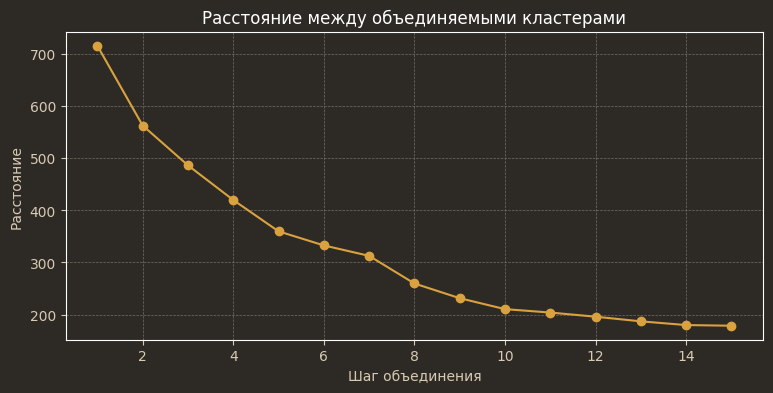

cluster
0    61
1    51
2    39
3    59
4    55
5    48
6    55
7    45
8    50
9    37
dtype: int64 

                B         C         D         E         F         G         H
cluster                                                                      
0        0.852459  0.918033  0.000000  0.885246  1.000000  0.852459  0.803279
1        1.000000  0.098039  0.941176  0.274510  0.098039  0.921569  0.000000
2        0.820513  0.000000  0.846154  0.923077  1.000000  0.000000  0.897436
3        0.847458  1.000000  1.000000  0.932203  0.000000  0.915254  1.000000
4        0.945455  0.854545  1.000000  1.000000  1.000000  0.909091  0.927273
5        0.229167  1.000000  0.979167  0.916667  0.062500  0.916667  0.000000
6        0.890909  0.000000  0.818182  0.927273  0.000000  0.872727  1.000000
7        0.000000  0.000000  0.866667  0.155556  0.222222  0.888889  0.133333
8        0.880000  1.000000  0.000000  0.940000  0.000000  0.960000  0.900000
9        0.918919  0.918919  1.000000  

In [23]:
n_clusters=10
max_iter=300
random_state=0

kmeans = kmeans_clustering(df_numeric, n_clusters=n_clusters, max_iter=max_iter, random_state=random_state)

kmeans.plot_distance_change()

print(kmeans.cluster_size(), '\n')
print(kmeans.mean_by_cluster(), '\n')

try:
    print(f'Silhouette Coefficient: {silhouette_score(df_numeric, kmeans.kmeans.labels_):.3f}')
except:
    pass

Здесь следующее распределение цифр:

- кластер 0 - 6

- кластер 1 - 7

- кластер 2 - 2

- кластер 3 - 9

- кластер 4 - 8

- кластер 5 - 4

- кластер 6 - 3

- кластер 7 - 1

- кластер 8 - 5

- кластер 9 - 0

In [24]:
# Преобразуем кластеры в числовой эквивалент
new_df = kmeans._df_result.copy()

mapping_predictions = {0: 6,
                       1: 7, 
                       2: 2, 
                       3: 9, 
                       4: 8, 
                       5: 4, 
                       6: 3, 
                       7: 1,
                       8: 5,
                       9: 0}

new_df['prediction'] = new_df['cluster'].replace(mapping_predictions)
new_df['true'] = new_df.reset_index().replace(mapping_dict).set_index(df_numeric.index)['A']

yes = new_df[new_df['prediction'] == new_df['true']]

print(f'Доля правильных ответов = {len(yes) / len(new_df)}')

Доля правильных ответов = 0.738


Через кластеризацию K-means точность повысилась ещё на 13% и составила 73.8%